In [7]:
import json
from queue import PriorityQueue
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

input = 'adj_ncm1_mr25_lps3.json'
with open(input, 'rb') as fp:
    data = json.load(fp)

adj_data = data['adj']
num_NMC = data['num_NMC']
num_LPS = data['num_LPS']
num_particle = data['num_particle']
vertical_dist_data = data['vertical_dist']
particle_rads_data = data['particle_rads']
particle_type_data = data['type']
SYS_thk = data['thickness']

adj = {}
# count = 0
for key in adj_data.keys():
    bool = False
    value = {}
    # if not adj_data[key].keys() and particle_type_data[key] == 'NMC':
    #     count += 1
    for i in adj_data[key].keys():
        # if adj_data[key][i][2] == 'LPS':
        #     bool = True
        value[int(i)] = adj_data[key][i]
    # if not bool and particle_type_data[key] == 'NMC':
    #     count += 1
    adj[int(key)] = value
# print('count', count)  # number of NMC particles that have no neighbor
# print(adj[404])  # last NMC particle has no neighbor particles!

vertical_dist = {int(key): value for key, value in vertical_dist_data.items()}
particle_rads = {int(key): value for key, value in particle_rads_data.items()}
particle_type = {int(key): value for key, value in particle_type_data.items()}

# Helper function


def heuristic(x):
    if x < 0 or x >= num_particle:
        raise IndexError('Index out of bound.')
    return vertical_dist[x]


def path_finder(s):
    if particle_type[s] != 'NMC':
        raise IndexError('Only consider NMC particles!')

    dist_so_far = [float('inf')] * num_particle
    parent = [None] * num_particle

    pq = PriorityQueue()

    dist_so_far[s] = 0
    source = (heuristic(s), s)
    parent[s] = s

    pq.put(source)
    while not pq.empty():
        _, temp = pq.get()
        if particle_type[temp] == 'Target':
            break
        for v in adj[temp].keys():
            if v == parent[temp] or particle_type[v] == 'NMC':
                continue
            dist = dist_so_far[temp] + adj[temp][v][0]
            if dist < dist_so_far[v]:
                parent[v] = temp
                dist_so_far[v] = dist
                pq.put((dist + heuristic(v), v))

    if not parent[-1]:
        return [], float('inf')

    shortest_path = [num_particle - 1]
    path_length = 0
    particle_on_path = num_particle - 1
    while True:
        v = parent[particle_on_path]
        if v == particle_on_path:
            break
        shortest_path.append(v)
        path_length += adj[v][particle_on_path][0]
        particle_on_path = v
    return list(reversed(shortest_path)), path_length
###

In [3]:
# Define parameters
pi      = 3.1415926
# Faradary constant, in unit s*A/mol
cn_F    = 96485.3329
# Density of NMC, in unit g/cm^3
den_ncm = 4.85
# Molar mass of NMC, in unit g/mol
mss_ncm = 96.95406
# Theoretic Specific capacity for NMC, in unit mAh/g
Qs_max  = cn_F/mss_ncm /3.6
#print(Qs_max)

# The current density used in the cell, in unit mA/cm^2
I0      = 0.05
# The area of the model, in unit um^2
A0      = 6400
# Sgm is the conductivity of bulkLPS 0.3mS/cm, here in unit S/um
sgm     = 3*1e-8
# first parameter for GB: lammada_1 = 2*Sgm_bulkLPS*Thickness_GB/Sgm_GBLPS
lmd_1   = 0.2
# Second parameter for NCM: lammada_2 = Sgm_bulkLPS/Sgm_NCM
#lmd_2 = 53.3
lmd_2   = 53.3*1e-3/2
# Define the initial timestep to reduce artific numerical error, in unit s
dt_int  = 0.000001
# Define the number of timesteps for the initial part
N_int   = 1000
# Define the timestep, in unit s
dt      = 0.000001
# Define the total time want to simulate
T_tot   = 10.0

# Define variables
# The current that path through the model, in unit A
Imdl  = I0*A0*1e-11
# The total number of simulation steps
N_tot = int(T_tot/dt)

print([dt_int,dt])

[1e-06, 1e-06]


In [4]:
# Shortest path
shortest_paths = {}
vol_NMC = 0.
vol_active_NMC = 0.
Om_path = []
vol_nmc_path = []
OmIvt_tot  = 0.
num_active_NMC = 0

for s in range(num_NMC):
    path, length = path_finder(s)
    vol_NMC += particle_rads[s]**3
    if path:
        vol_active_NMC += particle_rads[s]**3
        shortest_paths[num_active_NMC] = [length, vertical_dist[s],  particle_rads[s], path]
        num_active_NMC += 1
# Compute resistance from Li+ diffusion in NCM
        R_c   = particle_rads[s]
        tmp1  = adj_data[str(path[0])]
        tmp2  = tmp1[str(path[1])]
        Dlt_c = abs(tmp2[1])
        if len(path) == 2:
            R_Nc = R_c
        else:
            R_N  = particle_rads[path[1]]
            R_Nc = R_c*R_N/(R_c + R_N)
        
        tmp3  = math.sqrt(1 - 2*R_Nc*Dlt_c/(R_c*R_c))
        Om_c  = math.log((1+tmp3)/(1-tmp3))/R_c
    
# Compute resistance along each path, including LPS bulk resistance R_blk and LPS GB resistance R_gb
        if len(path) == 2:
            Om_b  = 0.
            Om_g  = 0.
        else:
            R_1    = particle_rads[path[-2]]
            R_2    = particle_rads[path[-3]]
            adj1   = adj_data[str(path[-2])]
            tmp    = adj1[str(path[-1])]
            Dlt_01 = abs(tmp[1])
            tmp    = adj1[str(path[-3])]
            Dlt_12 = abs(tmp[1])            
            R_12   = R_1*R_2/(R_1 + R_2)
            cn1    = math.sqrt(1 - 2*Dlt_01/R_1)
            cn2    = math.sqrt(1 - 2*R_12*Dlt_12/(R_1*R_1))
            Om_g   = 1.0/(2*R_1*Dlt_01)
            Om_b   = math.log((1+cn1)/(1-cn1) * (1+cn2)/(1-cn2))/R_1           

            if len(path) > 3:
#                print(path)
                for ilps in range(1, len(path)-2):
                  R_i      = particle_rads[path[ilps]]
                  R_im     = particle_rads[path[ilps-1]]
                  R_ip     = particle_rads[path[ilps+1]]
                  adji     = adj_data[str(path[ilps])]
                  tmp      = adji[str(path[ilps-1])]
                  Dlt_im   = abs(tmp[1])
                  tmp      = adji[str(path[ilps+1])]
                  Dlt_ip   = abs(tmp[1])
                  R_imi    = R_im*R_i/(R_im + R_i)
                  R_ipi    = R_ip*R_i/(R_ip + R_i)
                  cn1      = math.sqrt(1 - 2*R_imi*Dlt_im/(R_i*R_i))
                  cn2      = math.sqrt(1 - 2*R_ipi*Dlt_ip/(R_i*R_i))
#                  print([path[ilps],R_i, R_ip, Dlt_ip])
                  Om_g     = Om_g + (1.0/R_i + 1.0/R_ip)/(2*Dlt_ip)
                  Om_b     = Om_b + math.log((1+cn1)/(1-cn1) * (1+cn2)/(1-cn2))/R_i

        Om_g     = lmd_1*Om_g/(2*pi*sgm)
        Om_b     = Om_b/(2*pi*sgm)
        Om_c     = lmd_2*Om_c/(2*pi*sgm)
        Om_pathi = Om_g + Om_b + Om_c
        Om_path.append(Om_pathi)

        print([Om_g,Om_b,Om_c])

#  Volume of the NMC at current path
        vol_tmp = 4/3.0 * pi * R_c**3
        vol_nmc_path.append(vol_tmp)
        if Om_pathi > 0:
           OmIvt_tot = OmIvt_tot + 1.0/Om_pathi

print(OmIvt_tot)
print(num_active_NMC)
print(len(Om_path))

[354638633.24329937, 289331170.5116495, 354623.7663531157]
[126386794.70737198, 115984112.31262602, 343750.5054589588]
[191640185.4444852, 158939614.2101328, 369262.063053051]
[1038735.8598189001, 24642520.691492684, 345028.1078979577]
[1137030068.2329566, 571468493.1349952, 463241.3113928067]
[671912785.9864264, 314276162.68183804, 444587.4253604394]
[0.0, 0.0, 236416.29375836364]
[47907456.137303196, 104212262.49593474, 404699.4143730446]
[337349274.000575, 457902755.09381527, 355302.5970144832]
[329322221.1268013, 287952313.5212044, 349804.4597712436]
[1247180918.6502128, 862570961.1086242, 404969.29700726626]
[2394278.110566248, 37425564.82458825, 491993.37278513995]
[5721982278.755576, 791948933.4666597, 417557.6272417972]
[583859432.5180387, 498787032.7638556, 377052.98207570746]
[615294294.5933386, 536321327.65683824, 382633.19178855774]
[95822688.99456021, 113914315.55061156, 390044.8025487817]
[471162482.5838325, 448564228.1572713, 422373.71201922937]
[677796395.7971821, 38872

[443215335.394058, 409163840.64134, 420411.7799054615]
[5591895880.683141, 740599957.7736503, 388807.37331871176]
[315507066.9715399, 245421709.2364223, 390922.29346828384]
[60590173.60636447, 80464102.07680519, 492012.40051864256]
[0.0, 0.0, 272463.86789936153]
[1819180047.8893547, 714791954.8613545, 427942.32197649224]
[36525894.036805056, 67191866.15587047, 363806.36497769953]
[1280070316.794126, 728078517.8269037, 387258.55155636446]
[0.0, 0.0, 291200.75858252245]
[56381961.043751694, 104155735.1308379, 369112.0368947197]
[543081365.5218178, 526692970.9744077, 384910.29590809427]
[150960456.49465814, 80810161.06127663, 364122.9809942931]
[1468291229.1603985, 828216241.2699559, 373346.06243911904]
[1415605867.313644, 879470991.6228374, 391144.2122283225]
[587950038.0817391, 461743650.92457837, 393942.7462569018]
[125813142.9177146, 121660437.04945903, 457809.67616336985]
[226569564.51866356, 236896674.41165462, 385171.85645726306]
[1667364358.7836826, 764916354.4838072, 371972.28041

[370796890.8421476, 361994327.5409355, 372017.1508103652]
[1241914751.2562819, 429391766.30886805, 431851.76121411985]
[563327853.914777, 461108243.31420773, 367267.5588121598]
[642666579.2548275, 388008006.7601913, 381399.21419667476]
[404377365.1757628, 246803625.06718522, 352680.9818807488]
[1247683103.7410216, 829206119.2703981, 375668.51389090985]
[303335870.604397, 420220331.6239534, 388842.86191168247]
[158350588.30885988, 117903835.67848784, 347139.33589549205]
[898737200.2418778, 318265550.03336513, 386354.7656359705]
[1349013.7030284137, 28316892.099648856, 384459.5485830238]
[297384230.19646657, 249336694.22410122, 414133.4587876464]
[989978597.543226, 308386585.9162446, 374706.3442650588]
[6692203729.797219, 1437866080.447493, 367865.7232791456]
[903107202.9399836, 560306813.7530679, 382233.4625201166]
[1087455212.8710659, 299761460.1312665, 385944.35642006015]
[1015255823.5804867, 659287009.5395528, 389680.0425269238]
[326794836.4923631, 206629310.70429632, 347095.03687857

In [5]:
# The mass of total active NMC particles, in unit g
mdl_mass = 4*pi/3*vol_NMC*den_ncm*1e-12

# Read the Li extracted percentage V.S. voltage file
LiX  = []
Vltg = []
fi = open('x_voltage', 'r')
lines = fi.readlines()
for line in lines:
    line = line.rstrip()
    dta = [float(x) for x in line.split()]
    LiX.append(dta[0])
    Vltg.append(dta[1])

# Interpolate according to x-V curve
fxv = interpolate.interp1d(LiX, Vltg)
LiX_max = max(LiX)
Ucell_max = max(Vltg)
print(min(Vltg))
print(max(Vltg))

# Get the current passing through each path at each timestep
# The voltage of active CAM particles at each timestep
#V_Lix    = [0 for x in range(N_tot)]
V_Lix    = [0 for x in range(len(Om_path))]
# The voltage of the cathode composite
Ucell    = [0 for x in range(N_tot)]
Ucell[0] = Imdl/OmIvt_tot
# The capacity of the cell
Qcell    = [0 for x in range(N_tot)]
# The Li+ content extracted from NMC in Li(1-x)(NMC)
Lix_path = [0 for x in range(len(Om_path))]

nstep = 0
ioQ  = 0
ioU  = 0
nout = 100
cnst = [0 for x in range(len(Om_path))]
for ipath in range(len(Om_path)):
  cnst[ipath]=mss_ncm/(den_ncm*vol_nmc_path[ipath]*cn_F) * dt_int *1e12

for idt in range(1,N_tot):
  nstep = nstep + 1
# The specific capacity at current time: Qs(t) = summation(Imdl*dt)/M_ncm, in unit mAh/g
  if not idt%nout :
     ioQ = ioQ + 1
#    Qcell[ioQ] = idt*dt*Imdl/mdl_mass/3.6
     crnt_t     = idt*dt_int
     Qcell[ioQ] = crnt_t*Imdl/mdl_mass/3.6

  Cnt_path = [0 for x in range(len(Om_path))]
# Calculate the effective term
  tmp = 0.
  for ipath in range(len(Om_path)):
     tmp = tmp + V_Lix[ipath]/Om_path[ipath]

  for ipath in range(len(Om_path)):
# Calculate the current
     Cnt_path[ipath] = (Imdl+tmp)/(Om_path[ipath]*OmIvt_tot) - V_Lix[ipath]/Om_path[ipath]
#     if not ipath%100 :
#       print([V_Lix[ipath]*1,Om_path[ipath]*Cnt_path[ipath]])
    
# The voltage of the cell
     if ipath == 1 and not idt%nout :
       ioU = ioU + 1
       Ucell[ioU] = V_Lix[ipath] + Om_path[ipath]*Cnt_path[ipath]
       print([crnt_t, Qcell[ioU], Ucell[ioU]])
       with open('volt.txt', 'a') as fvlt:
          fvlt.write('%12.6f %20.16f %20.16f \n'%(crnt_t, Qcell[ioU], Ucell[ioU]))
#     Ucell[idt] = V_Lix[ipath] + Om_path[ipath]*Cnt_path[ipath]
    
# Conver the current to change of Li content in Li(1-x)(NMC)
     Lix_path[ipath] = Lix_path[ipath] + cnst[ipath] * Cnt_path[ipath]
#     print(Lix_path[ipath])
# If any extraction is larger than cutoff Li content, stop the cell
     if Lix_path[ipath] > LiX_max:
        break
#     elif Lix_path[ipath] < 0.0:
#        Lix_path[ipath] = 0.0      
# If not reach the cutoff, continue
# According to the x-V curve, interpolate to get the Voltage of NMC at each Lix
     V_Lix[ipath] = fxv(Lix_path[ipath])   
    
#  if not nstep%100:
#    print(nstep)
    
if 0: 
 for ipath in range(len(Om_path)):
   cnst[ipath] = cnst[ipath] * dt/dt_int

 for idt in range(N_int,N_tot):
  nstep = nstep + 1
# The specific capacity at current time: Qs(t) = summation(Imdl*dt)/M_ncm
  if not idt%nout :
    ioQ        = ioQ + 1
    crnt_t     = N_int*dt_int+(idt-N_int)*dt
    Qcell[ioQ] = crnt_t*Imdl/mdl_mass/3.6

  Cnt_path = [0 for x in range(len(Om_path))]
# Calculate the effective term
  tmp = 0.
  for ipath in range(len(Om_path)):
     tmp = tmp + V_Lix[ipath]/Om_path[ipath]

  for ipath in range(len(Om_path)):
# Calculate the current
     Cnt_path[ipath] = (Imdl+tmp)/(Om_path[ipath]*Om_tot) - V_Lix[ipath]/Om_path[ipath]
#     print([V_Lix[ipath],Om_path[ipath]*Cnt_path[ipath]])
# The voltage of the cell
     if ipath == 1 and not idt%nout :
       ioU = ioU + 1
       Ucell[ioU] = V_Lix[ipath] + Om_path[ipath]*Cnt_path[ipath]
       print([crnt_t, Qcell[ioU], Ucell[ioU]])
       with open('volt.txt', 'a') as fvlt:
          fvlt.write('%12.6f %20.16f %20.16f \n'%(crnt_t, Qcell[ioU], Ucell[ioU]))
        
#     Ucell[idt] = V_Lix[ipath] + Om_path[ipath]*Cnt_path[ipath]
#     print(Ucell[idt])
# Conver the current to change of Li content in Li(1-x)(NMC)
     Lix_path[ipath] = Lix_path[ipath] + cnst[ipath] * Cnt_path[ipath]
#     print(Lix_path[ipath])
# If any extraction is larger than cutoff Li content, stop the cell
     if Lix_path[ipath] > LiX_max:
        break
#     elif Lix_path[ipath] < 0.0:
#        Lix_path[ipath] = 0.0
# If not reach the cutoff, continue
# According to the x-V curve, interpolate to get the Voltage of NMC at each Lix
     V_Lix[ipath] = fxv(Lix_path[ipath])
  
# If any extraction is larger than cutoff Li content, stop the cell
  if Ucell[idt] > Ucell_max:
    break
    


2.030996
4.300006866
[9.999999999999999e-05, 2.062041213151401e-07, 2.031420800680761]
[0.00019999999999999998, 4.124082426302802e-07, 2.0316768228023183]
[0.0003, 6.186123639454202e-07, 2.031875478577788]
[0.00039999999999999996, 8.248164852605604e-07, 2.0320462516690028]
[0.0005, 1.0310206065757005e-06, 2.032199097597727]
[0.0006, 1.2372247278908404e-06, 2.0323387248516602]
[0.0007, 1.4434288492059806e-06, 2.0324680398583235]
[0.0007999999999999999, 1.6496329705211207e-06, 2.0325890957183597]
[0.0009, 1.8558370918362609e-06, 2.032703427307526]
[0.001, 2.062041213151401e-06, 2.0328122120531353]
[0.0010999999999999998, 2.2682453344665407e-06, 2.0329163669889656]
[0.0012, 2.474449455781681e-06, 2.03301661469091]
[0.0013, 2.680653577096821e-06, 2.033113530468065]
[0.0014, 2.886857698411961e-06, 2.0332075769648132]
[0.0015, 3.0930618197271017e-06, 2.033299129875512]
[0.0015999999999999999, 3.2992659410422414e-06, 2.033388497232358]
[0.0017, 3.5054700623573816e-06, 2.033475933982808]
[0.00

[0.0147, 3.0312005833325593e-05, 2.0416551528809794]
[0.014799999999999999, 3.051820995464073e-05, 2.041705458735225]
[0.0149, 3.0724414075955875e-05, 2.0417556529393845]
[0.015, 3.093061819727101e-05, 2.041805743152569]
[0.015099999999999999, 3.113682231858616e-05, 2.0418557133997046]
[0.0152, 3.1343026439901295e-05, 2.041905567126019]
[0.0153, 3.154923056121643e-05, 2.041955310934452]
[0.015399999999999999, 3.175543468253157e-05, 2.0420049528229542]
[0.0155, 3.1961638803846715e-05, 2.0420544921157324]
[0.0156, 3.216784292516186e-05, 2.0421039264656775]
[0.0157, 3.2374047046476997e-05, 2.0421532448050597]
[0.015799999999999998, 3.2580251167792134e-05, 2.0422024430232786]
[0.0159, 3.278645528910728e-05, 2.042251518161255]
[0.016, 3.2992659410422416e-05, 2.0423004778339475]
[0.0161, 3.3198863531737554e-05, 2.042349327936521]
[0.0162, 3.34050676530527e-05, 2.042398076583029]
[0.0163, 3.3611271774367836e-05, 2.042446728646358]
[0.016399999999999998, 3.381747589568297e-05, 2.04249528913895

[0.0295, 6.083021578796633e-05, 2.0482636651966457]
[0.029599999999999998, 6.103641990928146e-05, 2.0483029577228318]
[0.029699999999999997, 6.12426240305966e-05, 2.048342214117106]
[0.0298, 6.144882815191175e-05, 2.0483814316350983]
[0.0299, 6.165503227322689e-05, 2.0484206027510807]
[0.03, 6.186123639454203e-05, 2.0484597312963473]
[0.0301, 6.206744051585716e-05, 2.0484988207683896]
[0.030199999999999998, 6.227364463717231e-05, 2.0485378693056764]
[0.030299999999999997, 6.247984875848744e-05, 2.048576870976614]
[0.0304, 6.268605287980259e-05, 2.048615828209675]
[0.0305, 6.289225700111774e-05, 2.0486547438215537]
[0.0306, 6.309846112243287e-05, 2.048693618851119]
[0.030699999999999998, 6.330466524374802e-05, 2.04873245640707]
[0.030799999999999998, 6.351086936506314e-05, 2.0487712555798647]
[0.030899999999999997, 6.371707348637829e-05, 2.0488100152391273]
[0.031, 6.392327760769343e-05, 2.0488487347028603]
[0.0311, 6.412948172900857e-05, 2.048887409254175]
[0.0312, 6.433568585032372e-0

KeyboardInterrupt: 

-0.0989


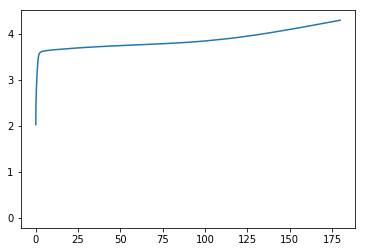

In [808]:
T_real = N_int*dt_int + (nstep-N_int)*dt
print(T_real)

LiII = [0 for x in range(len(LiX))]
for i in range(len(LiX)):
  LiII[i]  = LiX[i]*Qs_max

plt.plot(LiII, Vltg, '-')

plt.plot(Qcell[:nstep], Ucell[:nstep], '-')

with open('ncm_mr25_lps3_I005.txt', 'w') as fout:
    for i in range(len(Qcell[:nstep])):
        fout.write('%s \t %s \n'%(Qcell[i], Ucell[i]))
        
#    for i in range(len(LiII)):
#        fout.write('%s \t %s \n'%(LiII, Vltg))

In [803]:
a=2
b=4
if a==1 and not b%2 :
    print(b)